In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

In [2]:
dataset = pd.read_csv(r'movie_reviews.csv')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# normalize datasets
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

In [3]:
'''
with open('train_result.txt','r') as file:
    data = file.read()

documents = data.split(",")
docs = [review[2:-1] for review in documents]
docs[-1] = docs[-1][:-1] # special for the last one

norm_train_reviews = docs

with open('test_result.txt','r') as file:
    data = file.read()

test_documents = data.split(",")
test_docs = [review[2:-1] for review in test_documents]
test_docs[-1] = test_docs[-1][:-1]

norm_test_reviews = test_docs # special for the last one
'''

In [4]:
print(len(norm_train_reviews))
print(len(norm_test_reviews))

35000
15000


## Tokenize train & test datasets

In [5]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

## Build Vocabulary Mapping (word to index)

In [6]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index + 1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index + 1
vocab_size = len(vocab_map)

# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))


Vocabulary Size: 80051
Sample slice of vocabulary map: {'happen': 11, 'first': 12, 'thing': 13, 'strike': 14, 'brutality': 15, 'unflinch': 16, 'scene': 17, 'violence': 18, 'set': 19, 'word': 20}


## Encode and Pad datasets & Encode prediction class labels

In [7]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [8]:
# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes = 2 # 1 for positive and 0 for negative
max_len = np.max([len(review) for review in tokenized_train])

# train review data corpus
# convert tokenized text review into numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] \
           for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen = max_len)

# Train prediction class labels
# convert text sentiment labesl (negative\positive) into binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

# Test review data corpus
# convert tokenized text review into numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX']
           for token in tokenized_review] \
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen = max_len)

# Test prediction class labels
# convert text sentiment labesl (negative\positive) into binary encodings (0/1)
test_y = le.fit_transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape,
      ' Test review vectors shape:', test_X.shape)


Max length of train review vectors: 1442
Train review vectors shape: (35000, 1442)  Test review vectors shape: (15000, 1442)


## Build the LSTM Model Architecture

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

# dimension for dense embeddings for each token
EMBEDDING_DIM = 128
# total LSTM units
LSTM_DIM = 64

In [10]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, 
                    output_dim = EMBEDDING_DIM, 
                    input_length = max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, 
               dropout = 0.2,
               recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


## Visualize model architecture

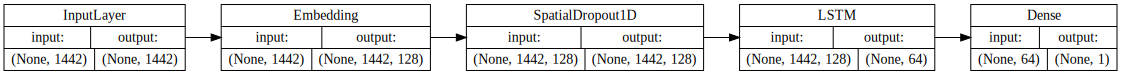

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

## Train the model

In [ ]:
# Reaaaaaaaaaaaaaaaaaaaally slow!! even with GPU
batch_size = 100
model.fit(train_X, train_y, epochs = 5, 
          batch_size = batch_size, shuffle = True,
          validation_split = 0.1, verbose = 1)

In [ ]:
'''
Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 1404s 45ms/step - loss: 0.0573 - acc: 0.9814 - val_loss: 0.5339 - val_acc: 0.8706
Epoch 2/5
19000/31500 [=================>............] - ETA: 8:49 - loss: 0.0426 - acc: 0.987231500/31500 [==============================] - 1368s 43ms/step - loss: 0.0448 - acc: 0.9867 - val_loss: 0.5247 - val_acc: 0.8640
Epoch 3/5
31500/31500 [==============================] - 1370s 43ms/step - loss: 0.0410 - acc: 0.9867 - val_loss: 0.5889 - val_acc: 0.8657
Epoch 4/5
 4900/31500 [===>..........................] - ETA: 18:45 - loss: 0.0247 - acc: 0.991831500/31500 [==============================] - 1370s 44ms/step - loss: 0.0301 - acc: 0.9901 - val_loss: 0.5821 - val_acc: 0.8663
Epoch 5/5
31500/31500 [==============================] - 1360s 43ms/step - loss: 0.0267 - acc: 0.9918 - val_loss: 0.6416 - val_acc: 0.8651
<keras.callbacks.History at 0x7f85d3f73438>
'''

## Predict and Evaluate Model Performance

In [ ]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

meu.display_model_performance_metrics(
    true_labels=test_sentiments,
    predicted_labels=predictions, 
    classes=['positive', 'negative'])


In [ ]:
'''
Model Performance metrics:
------------------------------
Accuracy: 0.8714
Precision: 0.8716
Recall: 0.8714
F1 Score: 0.8714

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.86      0.88      0.87      7510
   negative       0.88      0.86      0.87      7490

avg / total       0.87      0.87      0.87     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6637      873
        negative       1056     6434
'''